# Group Assignment #4: Spatial Analysis 

##### by Emily Cadena

### Who’s Most at Risk? Social Demographics and Traffic Collisions in the City of Los Angeles

#### This notebook examines the Spatial Autocorrelation Analysis of fatalities (bike and pedestrians) in the City of Los Angeles from 2015-2019 using UC Berkeley's Transportation Injury Mapping System (TIMS) data. 

### Data Sources & Geographic Information 
2019 Census Tracts from IPUMS NHGIS (At the time, we could not download the TIGER/Shapefile due to federal government actions).  
2015 - 2019 UC Berkeley - TIMS 

# Importing libraries 

In [218]:
# data exploration 
import pandas as pd

# merge data 
import geopandas as gpd

# basemaps
import contextily as ctx

# spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps  

# importing for plots and tables 
import matplotlib.pyplot as plt
import plotly.express as px

In [219]:
# la city census tracts (elected census tracts to keep our maps consistent) 
# use gpd because pandas cannot read shapefile 
la_tracts = gpd.read_file('data8/cityLA.zip')

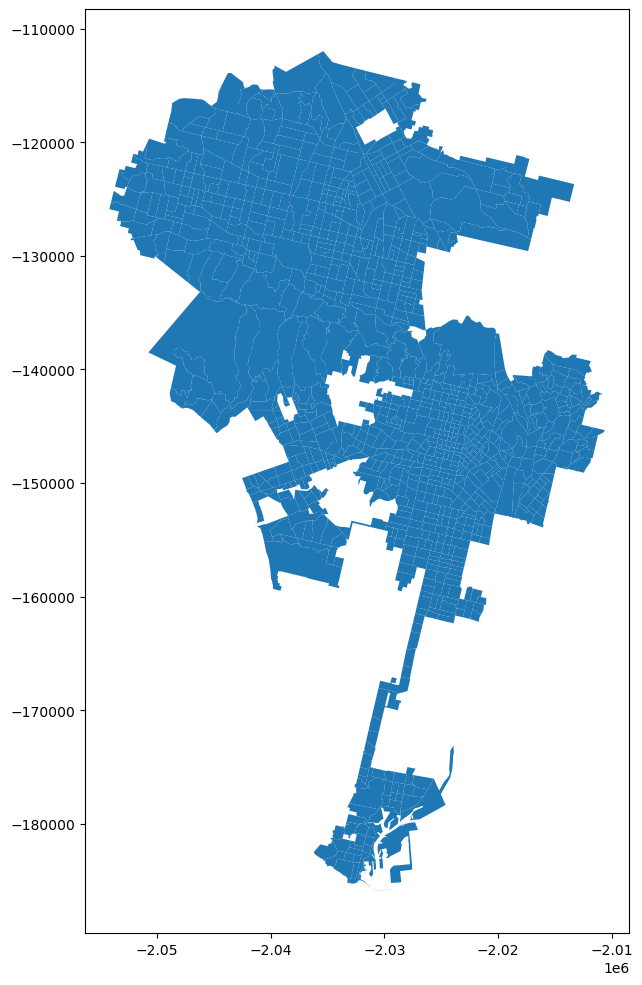

In [220]:
# plot census tracts using matplotlib
# keeping map size consistent with midterm maps 
# need to fix the tilt, unsuccessful so far 
fig,ax = plt.subplots(figsize=(12,12))
la_tracts.plot(ax=ax)

ax.set_aspect('equal')


In [221]:
# examing the data 
# do not have total population so we need to add our acs 2015-2019 and then merge 
la_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GISJOIN     1168 non-null   object  
 1   STATEFP     1168 non-null   object  
 2   COUNTYFP    1168 non-null   object  
 3   TRACTCE     1168 non-null   object  
 4   GEOID       1168 non-null   object  
 5   NAME        1168 non-null   object  
 6   NAMELSAD    1168 non-null   object  
 7   MTFCC       1168 non-null   object  
 8   FUNCSTAT    1168 non-null   object  
 9   ALAND       1168 non-null   float64 
 10  AWATER      1168 non-null   float64 
 11  INTPTLAT    1168 non-null   object  
 12  INTPTLON    1168 non-null   object  
 13  Shape_Leng  1168 non-null   float64 
 14  Shape_Le_1  1168 non-null   float64 
 15  Shape_Area  1168 non-null   float64 
 16  geometry    1168 non-null   geometry
dtypes: float64(5), geometry(1), object(11)
memory usage: 155.3+ KB


# Upload ACS 2015-2019 - To include Total Population 

In [222]:
# upload acs 2015-2019 data 
acs = pd.read_csv('data8/race15_19.csv')

In [223]:
# review rows and columns 
acs.shape

(2346, 39)

In [224]:
# need to eventually trim the data to only the FIPS, STATE, COUNTY, and Total Population ( B04001_001...from data dictionary)
acs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           2346 non-null   int64  
 1   Geo_GEOID          2346 non-null   object 
 2   Geo_NAME           2346 non-null   object 
 3   Geo_QName          2346 non-null   object 
 4   Geo_STUSAB         2346 non-null   object 
 5   Geo_SUMLEV         2346 non-null   int64  
 6   Geo_GEOCOMP        2346 non-null   int64  
 7   Geo_FILEID         2346 non-null   object 
 8   Geo_LOGRECNO       2346 non-null   int64  
 9   Geo_US             0 non-null      float64
 10  Geo_REGION         0 non-null      float64
 11  Geo_DIVISION       0 non-null      float64
 12  Geo_STATECE        0 non-null      float64
 13  Geo_STATE          2346 non-null   int64  
 14  Geo_COUNTY         2346 non-null   int64  
 15  Geo_COUSUB         0 non-null      float64
 16  Geo_PLACE          0 non

In [225]:
# leading zero is missing 
acs.head(2)

Geo_FIPS           Geo_GEOID              Geo_NAME  \
0  6037101110  14000US06037101110  Census Tract 1011.10   
1  6037101122  14000US06037101122  Census Tract 1011.22   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Census Tract 1011.10, Los Angeles County, Cali...         ca         140   
1  Census Tract 1011.22, Los Angeles County, Cali...         ca         140   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO  Geo_US  ...  SE_B04001_010  \
0            0      ACSSF          3871     NaN  ...           1188   
1            0      ACSSF          3872     NaN  ...            147   

   PCT_SE_B04001_002  PCT_SE_B04001_003  PCT_SE_B04001_004  PCT_SE_B04001_005  \
0              72.26              61.08               0.44               0.07   
1              95.68              84.64               2.17               0.44   

   PCT_SE_B04001_006  PCT_SE_B04001_007  PCT_SE_B04001_008  PCT_SE_B04001_009  \
0               7.73               0.07               0.19               2.69   
1               6.46               0.00               0.00               1.97   

   PCT_SE_B04001_010  
0              27.74  
1               4.32  

[2 rows x 39 columns]

# Converting Data Types for future use 

In [226]:
acs = pd.read_csv('data8/race15_19.csv', 
                   dtype=
                   {'Geo_FIPS': str, 
                  'Geo_STATE': str, 
                  'Geo_COUNTY': str })

In [227]:
# leading zero is present 
acs.head(2)

Geo_FIPS           Geo_GEOID              Geo_NAME  \
0  06037101110  14000US06037101110  Census Tract 1011.10   
1  06037101122  14000US06037101122  Census Tract 1011.22   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Census Tract 1011.10, Los Angeles County, Cali...         ca         140   
1  Census Tract 1011.22, Los Angeles County, Cali...         ca         140   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO  Geo_US  ...  SE_B04001_010  \
0            0      ACSSF          3871     NaN  ...           1188   
1            0      ACSSF          3872     NaN  ...            147   

   PCT_SE_B04001_002  PCT_SE_B04001_003 PCT_SE_B04001_004 PCT_SE_B04001_005  \
0              72.26              61.08              0.44              0.07   
1              95.68              84.64              2.17              0.44   

   PCT_SE_B04001_006  PCT_SE_B04001_007  PCT_SE_B04001_008  PCT_SE_B04001_009  \
0               7.73               0.07               0.19               2.69   
1               6.46               0.00               0.00               1.97   

   PCT_SE_B04001_010  
0              27.74  
1               4.32  

[2 rows x 39 columns]

In [228]:
# going into the column to review state and county 
print(acs.Geo_STATE.head(2))
print(acs.Geo_COUNTY.head(2))

0    06
1    06
Name: Geo_STATE, dtype: object
0    037
1    037
Name: Geo_COUNTY, dtype: object


In [229]:
### Cleaning and Reorganzing the data 

In [230]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           2346 non-null   object 
 1   Geo_GEOID          2346 non-null   object 
 2   Geo_NAME           2346 non-null   object 
 3   Geo_QName          2346 non-null   object 
 4   Geo_STUSAB         2346 non-null   object 
 5   Geo_SUMLEV         2346 non-null   int64  
 6   Geo_GEOCOMP        2346 non-null   int64  
 7   Geo_FILEID         2346 non-null   object 
 8   Geo_LOGRECNO       2346 non-null   int64  
 9   Geo_US             0 non-null      float64
 10  Geo_REGION         0 non-null      float64
 11  Geo_DIVISION       0 non-null      float64
 12  Geo_STATECE        0 non-null      float64
 13  Geo_STATE          2346 non-null   object 
 14  Geo_COUNTY         2346 non-null   object 
 15  Geo_COUSUB         0 non-null      float64
 16  Geo_PLACE          0 non

In [231]:
# keep columns 
# only keep B04001_001 - Total Population 
columns_to_keep = ['Geo_FIPS', 
                   'Geo_STATE', 
                   'Geo_COUNTY',
                   'Geo_TRACT',
                   'SE_B04001_001']

acs=acs[columns_to_keep]      

In [232]:
acs.head(2)

Geo_FIPS Geo_STATE Geo_COUNTY  Geo_TRACT  SE_B04001_001
0  06037101110        06        037     101110           4283
1  06037101122        06        037     101122           3405

In [233]:
#rename columns 
acs.columns = ['FIPS',
                'State',
                'County',
                'Census Tract',
                'Total Population']

In [234]:
# check
acs.head(2)

FIPS State County  Census Tract  Total Population
0  06037101110    06    037        101110              4283
1  06037101122    06    037        101122              3405

# Merge 

In [235]:
# add a FIPS column
# creating a new column so that I can merge the shapefile and census tracts
la_tracts['FIPS'] = '06' + '037' + la_tracts['TRACTCE']

In [236]:
# check new column
la_tracts.head(2)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  AWATER     INTPTLAT  \
0  Census Tract 1011.10  G5020        S  1142401.0     0.0  +34.2594737   
1  Census Tract 1011.22  G5020        S  2644045.0     0.0  +34.2677213   

       INTPTLON   Shape_Leng   Shape_Le_1    Shape_Area  \
0  -118.2929869  4585.520052  4585.520052  1.142400e+06   
1  -118.2901465  9652.233049  9652.233049  2.644046e+06   

                                            geometry         FIPS  
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  06037101110  
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...  06037101122

In [237]:
# need to merge to create a new dataframe 
# appears that the merging order matters 
la_city =la_tracts.merge(acs, on="FIPS")

In [238]:
la_city.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GISJOIN           1168 non-null   object  
 1   STATEFP           1168 non-null   object  
 2   COUNTYFP          1168 non-null   object  
 3   TRACTCE           1168 non-null   object  
 4   GEOID             1168 non-null   object  
 5   NAME              1168 non-null   object  
 6   NAMELSAD          1168 non-null   object  
 7   MTFCC             1168 non-null   object  
 8   FUNCSTAT          1168 non-null   object  
 9   ALAND             1168 non-null   float64 
 10  AWATER            1168 non-null   float64 
 11  INTPTLAT          1168 non-null   object  
 12  INTPTLON          1168 non-null   object  
 13  Shape_Leng        1168 non-null   float64 
 14  Shape_Le_1        1168 non-null   float64 
 15  Shape_Area        1168 non-null   float64 
 16  geometry        

In [239]:
la_city.head(2)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  ...      INTPTLON  \
0  Census Tract 1011.10  G5020        S  1142401.0  ...  -118.2929869   
1  Census Tract 1011.22  G5020        S  2644045.0  ...  -118.2901465   

    Shape_Leng   Shape_Le_1    Shape_Area  \
0  4585.520052  4585.520052  1.142400e+06   
1  9652.233049  9652.233049  2.644046e+06   

                                            geometry         FIPS State  \
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  06037101110    06   
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...  06037101122    06   

  County Census Tract Total Population  
0    037       101110             4283  
1    037       101122             3405  

[2 rows x 22 columns]

# Data Cleaning  

In [240]:
# reviewing the last row 
# last row has a population of 16 for census tracts 
la_city.tail(1)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
1167  G0600370980033      06      037  980033  06037980033  9800.33   

                  NAMELSAD  MTFCC FUNCSTAT       ALAND  ...      INTPTLON  \
1167  Census Tract 9800.33  G5020        S  12666626.0  ...  -118.2203101   

        Shape_Leng   Shape_Le_1  Shape_Area  \
1167  77121.442699  6045.962324   92.314193   

                                               geometry         FIPS State  \
1167  MULTIPOLYGON (((-2027800.331 -180973.621, -202...  06037980033    06   

     County Census Tract Total Population  
1167    037       980033               16  

[1 rows x 22 columns]

In [241]:
# sort by total population, found 20 census tracts with population less than 100 
la_city.sort_values(by='Total Population').head(25)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
1165  G0600370980030      06      037  980030  06037980030  9800.30   
1164  G0600370980028      06      037  980028  06037980028  9800.28   
1008  G0600370320000      06      037  320000  06037320000     3200   
1149  G0600370980002      06      037  980002  06037980002  9800.02   
1158  G0600370980020      06      037  980020  06037980020  9800.20   
1160  G0600370980022      06      037  980022  06037980022  9800.22   
1161  G0600370980023      06      037  980023  06037980023  9800.23   
1154  G0600370980013      06      037  980013  06037980013  9800.13   
1150  G0600370980005      06      037  980005  06037980005  9800.05   
1148  G0600370980001      06      037  980001  06037980001  9800.01   
1152  G0600370980009      06      037  980009  06037980009  9800.09   
1155  G0600370980014      06      037  980014  06037980014  9800.14   
1167  G0600370980033      06      037  980033  06037980033  9800.33   
1163  G0600370980026      06      037  980026  06037980026  9800.26   
1159  G0600370980021      06      037  980021  06037980021  9800.21   
1032  G0600370532400      06      037  532400  06037532400     5324   
1151  G0600370980008      06      037  980008  06037980008  9800.08   
1146  G0600370930101      06      037  930101  06037930101  9301.01   
1065  G0600370575500      06      037  575500  06037575500     5755   
1153  G0600370980010      06      037  980010  06037980010  9800.10   
1157  G0600370980019      06      037  980019  06037980019  9800.19   
1162  G0600370980024      06      037  980024  06037980024  9800.24   
1147  G0600370930200      06      037  930200  06037930200     9302   
1156  G0600370980015      06      037  980015  06037980015  9800.15   
934   G0600370277400      06      037  277400  06037277400     2774   

                  NAMELSAD  MTFCC FUNCSTAT        ALAND  ...      INTPTLON  \
1165  Census Tract 9800.30  G5020        S    4248789.0  ...  -118.4094782   
1164  Census Tract 9800.28  G5020        S   17299723.0  ...  -118.4160617   
1008     Census Tract 3200  G5020        S    1310258.0  ...  -118.3508573   
1149  Census Tract 9800.02  G5020        S    6773893.0  ...  -118.2386708   
1158  Census Tract 9800.20  G5020        S    8532139.0  ...  -118.3034056   
1160  Census Tract 9800.22  G5020        S    5391718.0  ...  -118.4807217   
1161  Census Tract 9800.23  G5020        S    2863946.0  ...  -118.6324389   
1154  Census Tract 9800.13  G5020        S    5308531.0  ...  -118.3871451   
1150  Census Tract 9800.05  G5020        S    4051700.0  ...  -118.3273387   
1148  Census Tract 9800.01  G5020        S    2315128.0  ...  -118.3575367   
1152  Census Tract 9800.09  G5020        S   20912226.0  ...  -118.2963873   
1155  Census Tract 9800.14  G5020        S    6478629.0  ...  -118.2384201   
1167  Census Tract 9800.33  G5020        S   12666626.0  ...  -118.2203101   
1163  Census Tract 9800.26  G5020        S   13865627.0  ...  -118.2633014   
1159  Census Tract 9800.21  G5020        S    6879980.0  ...  -118.3813338   
1032     Census Tract 5324  G5020        S   12497802.0  ...  -118.2109137   
1151  Census Tract 9800.08  G5020        S    3369326.0  ...  -118.4906762   
1146  Census Tract 9301.01  G5020        S  155751511.0  ...  -118.1390988   
1065     Census Tract 5755  G5020        S    1316269.0  ...  -118.2146254   
1153  Census Tract 9800.10  G5020        S    3757605.0  ...  -118.2395140   
1157  Census Tract 9800.19  G5020        S   44210349.0  ...  -118.5343628   
1162  Census Tract 9800.24  G5020        S    7998841.0  ...  -118.4883751   
1147     Census Tract 9302  G5020        S  304569513.0  ...  -118.2894308   
1156  Census Tract 9800.15  G5020        S    5188935.0  ...  -118.2888391   
934      Census Tract 2774  G5020        S     638940.0  ...  -118.3743485   

         Shape_Leng    Shape_Le_1    Shape_Area  \
1165    9017.881815    653.697955  6.943901e+00   
1164   25220.098297  25269.399427  

In [242]:
# delete population with less than 100
la_city = la_city[la_city['Total Population']>100]

In [243]:
la_city.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1148 entries, 0 to 1166
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GISJOIN           1148 non-null   object  
 1   STATEFP           1148 non-null   object  
 2   COUNTYFP          1148 non-null   object  
 3   TRACTCE           1148 non-null   object  
 4   GEOID             1148 non-null   object  
 5   NAME              1148 non-null   object  
 6   NAMELSAD          1148 non-null   object  
 7   MTFCC             1148 non-null   object  
 8   FUNCSTAT          1148 non-null   object  
 9   ALAND             1148 non-null   float64 
 10  AWATER            1148 non-null   float64 
 11  INTPTLAT          1148 non-null   object  
 12  INTPTLON          1148 non-null   object  
 13  Shape_Leng        1148 non-null   float64 
 14  Shape_Le_1        1148 non-null   float64 
 15  Shape_Area        1148 non-null   float64 
 16  geometry          114

# Come Back here and delete the code below (trim the data) if I continue having problems!!!

In [244]:
# trim the data again
la_city = la_city[['FIPS', 'Census Tract', 'Total Population', 'geometry']]

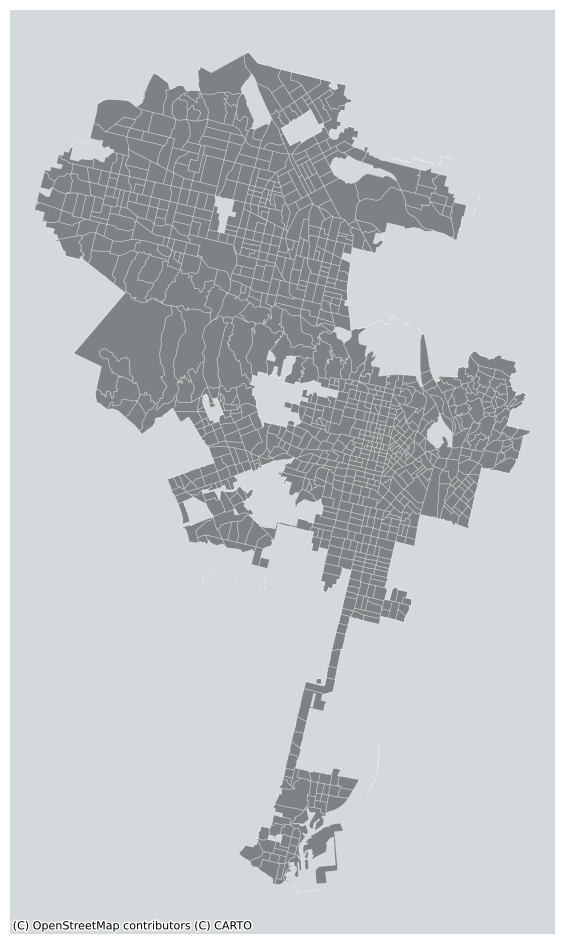

In [245]:
#plot census tract
fig, ax = plt.subplots(figsize=(12,12))

la_city.plot(ax=ax, 
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=.4)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [246]:
la_city.head(2)

FIPS  Census Tract  Total Population  \
0  06037101110        101110              4283   
1  06037101122        101122              3405   

                                            geometry  
0  POLYGON ((-2019033.589 -124429.155, -2018948.5...  
1  POLYGON ((-2017297.948 -125225.326, -2017305.0...

In [247]:
# checking projection
la_city.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# if there is a problem with projection - revisit this section

In [248]:
# changing projection
la_city=la_city.to_crs('EPSG:4326')

In [249]:
la_city.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

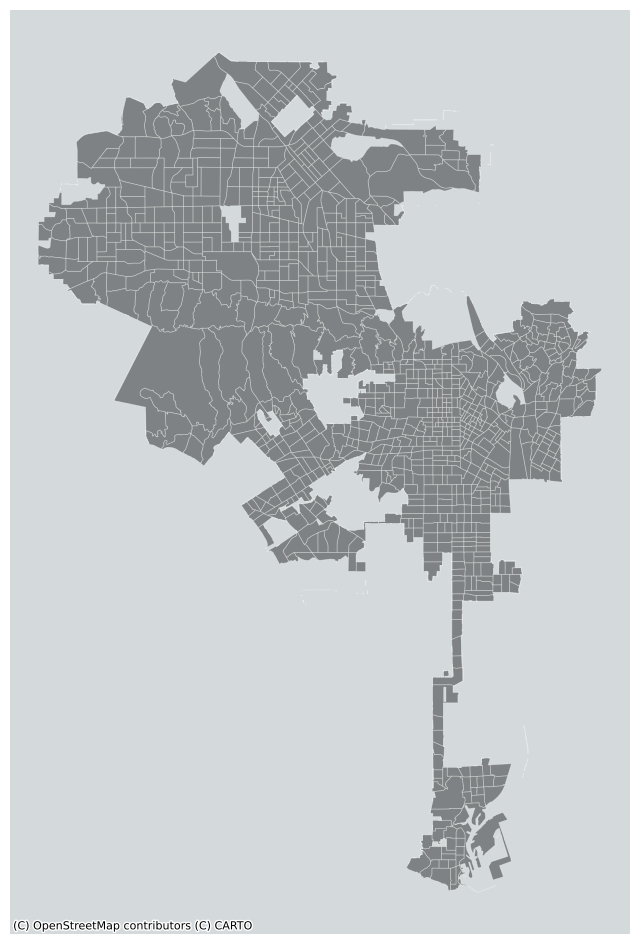

In [250]:
#plot census tract
fig, ax = plt.subplots(figsize=(12,12))

la_city.plot(ax=ax, 
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=.4)

ax.axis('off')

ctx.add_basemap(ax,zoom=12,source=ctx.providers.CartoDB.Positron)

# Add Crash Data 

In [251]:
# upload crash data 
# use pandas since we do not have geometry data 
crash = pd.read_csv('data8/Crashes.csv')

In [252]:
crash.shape

(1332, 80)

In [253]:
crash.head(2)

CASE_ID  ACCIDENT_YEAR   PROC_DATE  JURIS COLLISION_DATE  COLLISION_TIME  \
0  6292141           2015  2017-04-25   9590     2015-02-24            1700   
1  6292153           2015  2017-04-21   9590     2015-02-15             930   

  OFFICER_ID REPORTING_DISTRICT  DAY_OF_WEEK  CHP_SHIFT  ...  COUNT_MC_KILLED  \
0      20409                NaN            2          2  ...                1   
1      20436                NaN            7          1  ...                1   

   COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP  LATITUDE  LONGITUDE  \
0                 0            -               -   34.10310 -118.25006   
1                 0            -               -   34.02729 -118.21038   

        COUNTY         CITY     POINT_X    POINT_Y  
0  LOS ANGELES  LOS ANGELES -118.249825  34.106312  
1  LOS ANGELES  LOS ANGELES -118.216215  34.029824  

[2 rows x 80 columns]

In [254]:
# reviewing latitude ("y" below) and longitude ("x" below) 
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CASE_ID                  1332 non-null   int64  
 1   ACCIDENT_YEAR            1332 non-null   int64  
 2   PROC_DATE                1332 non-null   object 
 3   JURIS                    1332 non-null   int64  
 4   COLLISION_DATE           1332 non-null   object 
 5   COLLISION_TIME           1332 non-null   int64  
 6   OFFICER_ID               1330 non-null   object 
 7   REPORTING_DISTRICT       1067 non-null   object 
 8   DAY_OF_WEEK              1332 non-null   int64  
 9   CHP_SHIFT                1332 non-null   int64  
 10  POPULATION               1332 non-null   int64  
 11  CNTY_CITY_LOC            1332 non-null   int64  
 12  SPECIAL_COND             1332 non-null   int64  
 13  BEAT_TYPE                1332 non-null   int64  
 14  CHP_BEAT_TYPE           

# Problem may be here if we use a different project 

In [255]:
# convert data to geodataframe to plot 

crash = gpd.GeoDataFrame(crash, 
                         crs ='EPSG:4326', 
                         geometry=gpd.points_from_xy(crash.POINT_X, crash.POINT_Y))

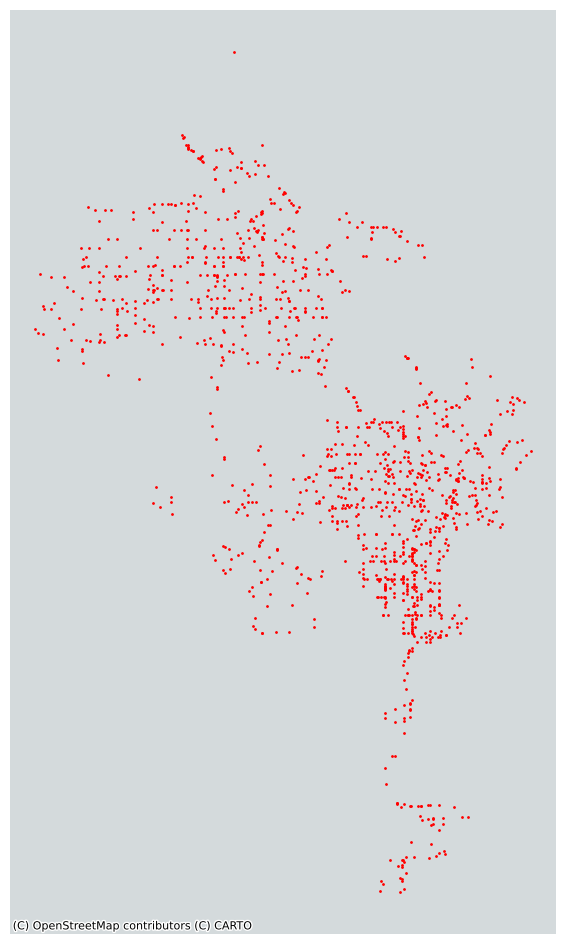

In [256]:
# map crash data
fig,ax = plt.subplots(figsize=(12,12))

crash.plot(ax=ax,
             color='red',
             markersize=1)

ax.axis('off')

ctx.add_basemap(ax,zoom=12, source=ctx.providers.CartoDB.Positron)

In [257]:
# calculating the bounds for crash data 
# purpose - we want to zoom into the crash layer and NOT census tracts 
minx, miny, maxx, maxy = crash.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-118.65164947509766
-118.16612243652344
33.720943450927734
34.40166091918945


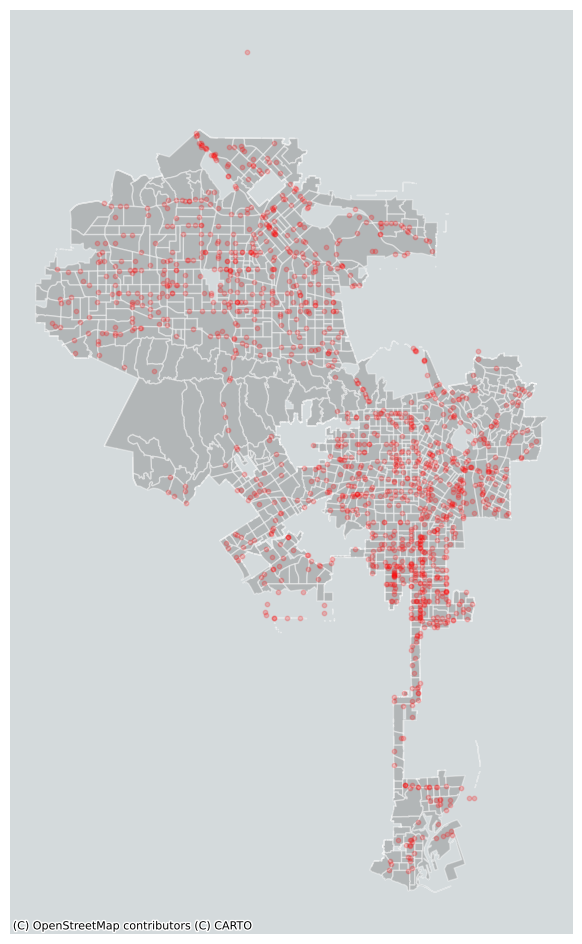

In [258]:
# creating subplots 
fig, ax = plt.subplots(figsize=(12, 12)) #maybe change to 20,20

# census tracts 
la_city.plot(ax=ax, 
        color='gray', 
        edgecolor='white',
        alpha=0.4)

# crash
crash.plot(ax=ax,
        color='red',
        markersize=10,
        alpha=0.2) 

# left out bounds because I got a wonky map

ax.axis('off')

ctx.add_basemap(ax, zoom=12, source=ctx.providers.CartoDB.Positron)

# Spatial Join

In [259]:
# review crash record first 
crash.shape

(1332, 81)

In [260]:
#spatial join - to figure out how many crashes are in a census tracts 
# left - identify the layer you want to attach information that will come from the other layer 
# this creates a dataframe that has every crash record with a correspoding FIPS code 
# three arguments (left dataframe, right dataframe and how statement 
#left - I'm sending the data from the right to the left (sending crash data to the census tracts?) 
join = gpd.sjoin(la_city, crash, how='left')

In [261]:
# this is a dataframe that has every crash that aligns with a FIPS Code 
join.shape

(1823, 85)

In [262]:
#new dataframe - which includes number killed # by census tracks 
crash_by_cs = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='NUMBER_KILLED')
crash_by_cs

FIPS  NUMBER_KILLED
0     06037226002             14
1     06037241202             13
2     06037127400              9
3     06037980024              9
4     06037232700              9
...           ...            ...
1143  06037703100              1
1144  06037703200              1
1145  06037800101              1
1146  06037800102              1
1147  06037800203              1

[1148 rows x 2 columns]

<Axes: xlabel='FIPS'>

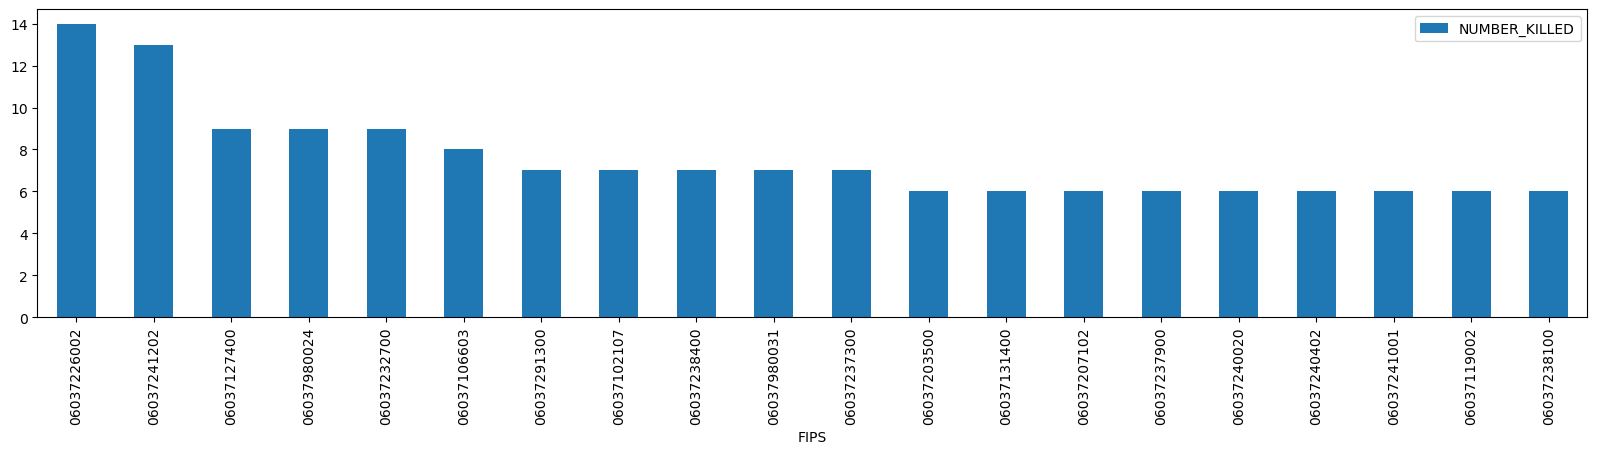

In [263]:
# preview of the top 20 gepgraphies with the highest number of people killed 
crash_by_cs[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='NUMBER_KILLED')

In [264]:
# descriptive stats for number_killed
crash_by_cs['NUMBER_KILLED'].describe()

count    1148.000000
mean        1.587979
std         1.263847
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: NUMBER_KILLED, dtype: float64

In [265]:
# merging here so that we can add the NUMBER_KILLED to our la_city_census tracts 
la_city=la_city.merge(crash_by_cs,on='FIPS')

In [266]:
la_city.head(10)

FIPS  Census Tract  Total Population  \
0  06037101110        101110              4283   
1  06037101122        101122              3405   
2  06037101210        101210              6347   
3  06037101220        101220              3702   
4  06037101300        101300              3884   
5  06037101400        101400              3458   
6  06037102103        102103              1763   
7  06037102104        102104              3721   
8  06037102105        102105              1905   
9  06037102107        102107              4349   

                                            geometry  NUMBER_KILLED  
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...              1  
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...              1  
2  POLYGON ((-118.28593 34.25589, -118.28593 34.2...              1  
3  POLYGON ((-118.28498 34.25589, -118.28449 34.2...              1  
4  POLYGON ((-118.26527 34.25238, -118.26527 34.2...              1  
5  POLYGON ((-118.29945 34.25598, -118.29792 34.2...              6  
6  POLYGON ((-118.34335 34.22587, -118.34348 34.2...              3  
7  POLYGON ((-118.33806 34.22227, -118.33837 34.2...              1  
8  POLYGON ((-118.34301 34.20656, -118.34317 34.2...              3  
9  POLYGON ((-118.33 34.25968, -118.32995 34.2596...              7

# Normalize by the number of people living in the census tract 

In [267]:
# new column "killed_per_1000" - the crash/killed rate 
la_city['killed_per_1000'] = la_city['NUMBER_KILLED']/la_city['Total Population']*1000

In [268]:
#hmm interesting rates 
la_city.head(10)

FIPS  Census Tract  Total Population  \
0  06037101110        101110              4283   
1  06037101122        101122              3405   
2  06037101210        101210              6347   
3  06037101220        101220              3702   
4  06037101300        101300              3884   
5  06037101400        101400              3458   
6  06037102103        102103              1763   
7  06037102104        102104              3721   
8  06037102105        102105              1905   
9  06037102107        102107              4349   

                                            geometry  NUMBER_KILLED  \
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...              1   
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...              1   
2  POLYGON ((-118.28593 34.25589, -118.28593 34.2...              1   
3  POLYGON ((-118.28498 34.25589, -118.28449 34.2...              1   
4  POLYGON ((-118.26527 34.25238, -118.26527 34.2...              1   
5  POLYGON ((-118.29945 34.25598, -118.29792 34.2...              6   
6  POLYGON ((-118.34335 34.22587, -118.34348 34.2...              3   
7  POLYGON ((-118.33806 34.22227, -118.33837 34.2...              1   
8  POLYGON ((-118.34301 34.20656, -118.34317 34.2...              3   
9  POLYGON ((-118.33 34.25968, -118.32995 34.2596...              7   

   killed_per_1000  
0         0.233481  
1         0.293686  
2         0.157555  
3         0.270124  
4         0.257467  
5         1.735107  
6         1.701645  
7         0.268745  
8         1.574803  
9         1.609565

In [269]:
#examining areas with most people killed 
la_city.sort_values(by="killed_per_1000").tail()

FIPS  Census Tract  Total Population  \
49    06037106603        106603              3156   
1147  06037980031        980031              1175   
1145  06037980019        980019               138   
702   06037226002        226002              1820   
1146  06037980024        980024               223   

                                               geometry  NUMBER_KILLED  \
49    POLYGON ((-118.49611 34.32107, -118.49616 34.3...              8   
1147  MULTIPOLYGON (((-118.24533 33.76374, -118.2437...              7   
1145  POLYGON ((-118.56402 34.13115, -118.56399 34.1...              1   
702   POLYGON ((-118.23861 34.03498, -118.23881 34.0...             14   
1146  POLYGON ((-118.50984 34.18662, -118.50791 34.1...              9   

      killed_per_1000  
49           2.534854  
1147         5.957447  
1145         7.246377  
702          7.692308  
1146        40.358744

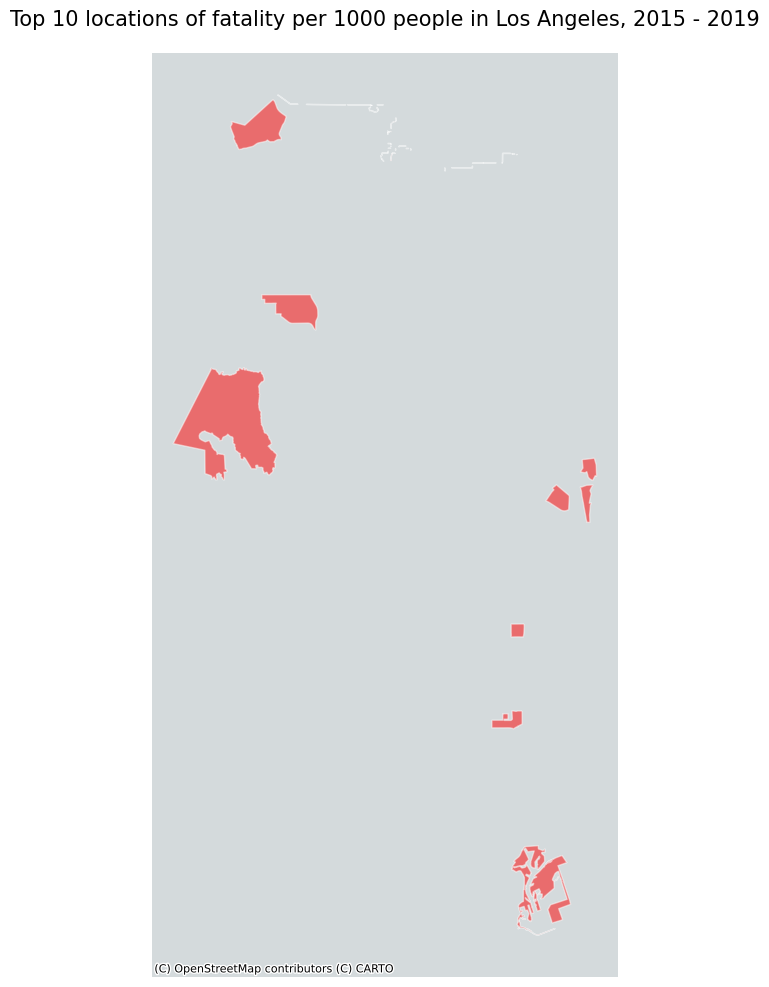

In [270]:
# seeing the location of the top 10 places folks are killed 
fig,ax = plt.subplots(figsize=(12,12))
la_city.sort_values(by='killed_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)


# title
ax.set_title('Top 10 locations of fatality per 1000 people in Los Angeles, 2015 - 2019',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax, zoom=14, source=ctx.providers.CartoDB.Positron)


# Maps

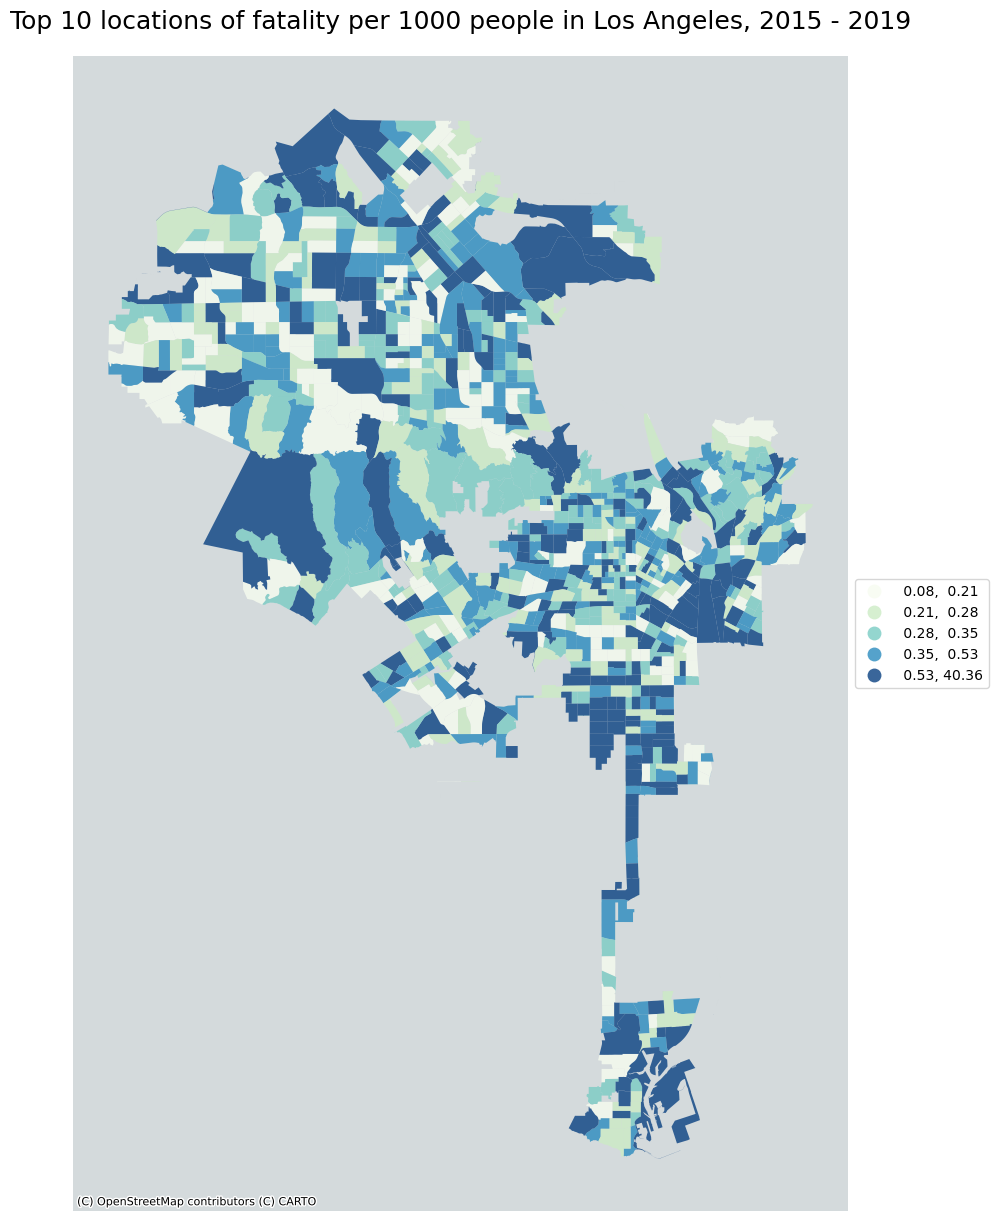

In [271]:
# Scheme - Quantiles - equal categories so not the best to use  
fig,ax = plt.subplots(figsize=(15,15))

la_city.plot(ax=ax,  
        column='killed_per_1000',
        legend=True,
        alpha=0.8,    
        cmap='GnBu', 
        scheme='quantiles',
        legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title('Top 10 locations of fatality per 1000 people in Los Angeles, 2015 - 2019',fontsize=18,pad=20)
ctx.add_basemap(ax, zoom= 12,source=ctx.providers.CartoDB.Positron)
# added zoom=12 because I keep getting an error message 

<Axes: ylabel='Frequency'>

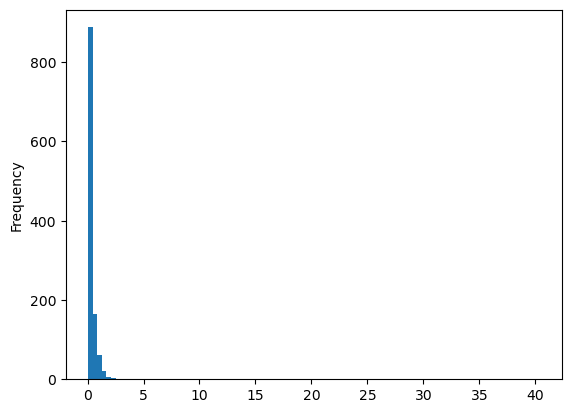

In [272]:
# checking if the data is skew 
# yes skewed right
la_city['killed_per_1000'].plot.hist(bins=100)

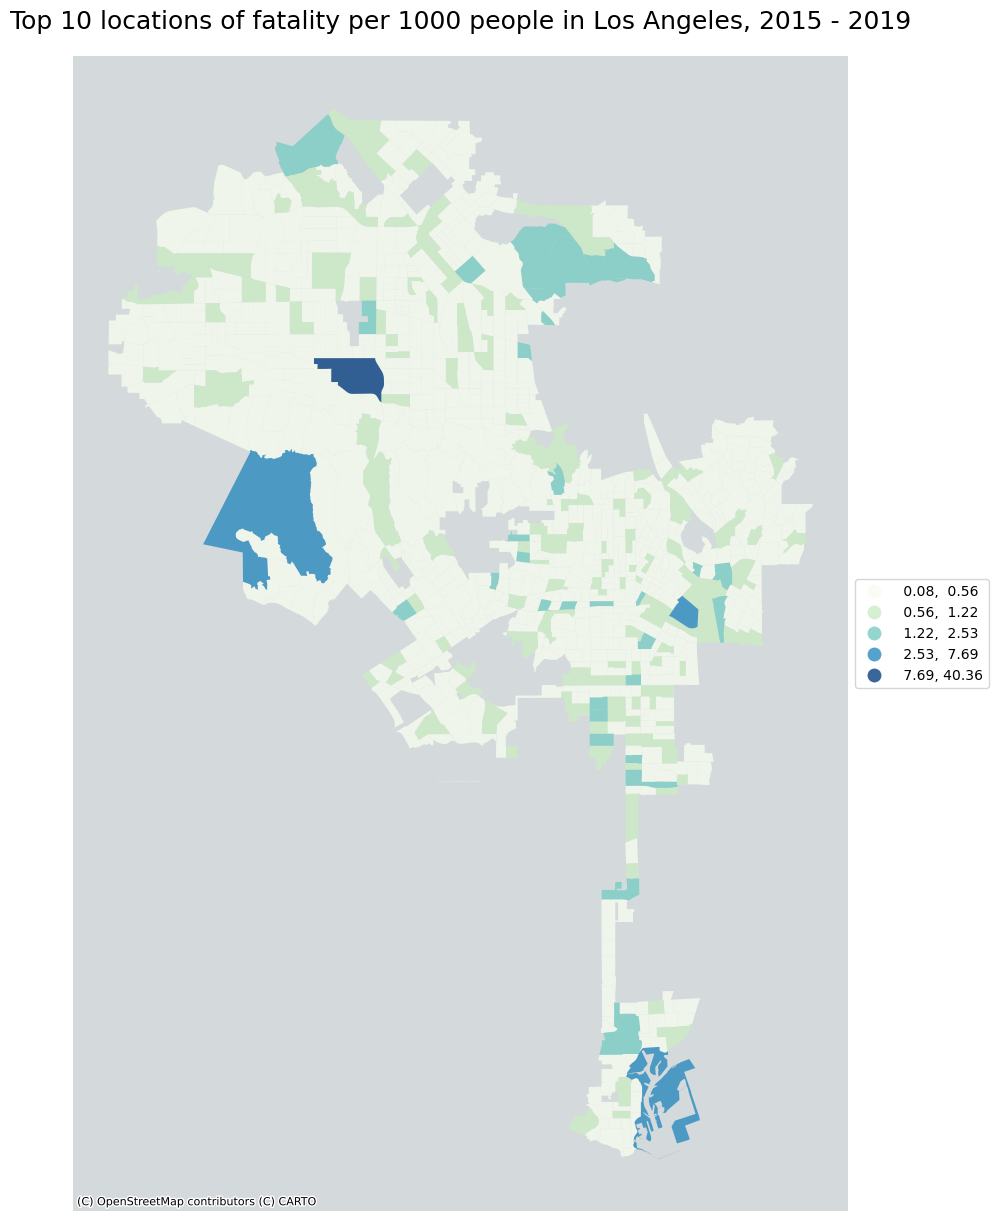

In [273]:
# Scheme - Quantiles - equal categories so not the best to use  
fig,ax = plt.subplots(figsize=(15,15))

la_city.plot(ax=ax,  
        column='killed_per_1000',
        legend=True,
        alpha=0.8,    
        cmap='GnBu', 
        scheme='naturalbreaks',
        legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title('Top 10 locations of fatality per 1000 people in Los Angeles, 2015 - 2019',fontsize=18,pad=20)
ctx.add_basemap(ax, zoom= 12,source=ctx.providers.CartoDB.Positron)

In [274]:
# interactive map 

la_city.explore(column='killed_per_1000', 
        legend=True,
        cmap='GnBu', 
        scheme='naturalbreaks',
        tiles='CartoDB positron',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        })

# Spatial Weights

In [275]:
# calculate spatial weight 
# we are setting up the spatial matrix & then the row standardization 
#def:
#spatial weight - lets us determine the area's neighborhood
# KNN weight - the number ofn"nearest neighbors" - to count calculations

wq =  lps.weights.KNN.from_dataframe(la_city,k=8)

# r - adjusts the weights in a spatial weights matrix:
#When weights are row standardized, each weight is divided by its row sum. The row sum is the sum of weights for a features neighbors
wq.transform = 'r'

# Spatial Lag 

In [276]:
# spatial lag 
# defintion: calculated assignment for each geography (census tracts) in data that accounts for data calyes from others in the nieghborhood (8 count)
# aka it takes the average of all the neighbors defined by the spatial weight to come up with a single associated value 
# creating new column which is equal to the weight 
la_city['killed_per_1000_lag']=lps.weights.lag_spatial(wq, la_city['killed_per_1000'])

In [277]:
#review sample 
la_city.sample(10)

FIPS  Census Tract  Total Population  \
871   06037269000        269000              4813   
134   06037119341        119341              2890   
1009  06037320201        320201              4049   
438   06037191620        191620              2532   
288   06037134710        134710              5836   
540   06037207301        207301              4911   
830   06037262302        262302              2845   
1028  06037531301        531301              4824   
800   06037240300        240300              5637   
715   06037228500        228500              4869   

                                               geometry  NUMBER_KILLED  \
871   POLYGON ((-118.40564 34.0571, -118.40509 34.05...              2   
134   POLYGON ((-118.44351 34.23991, -118.44137 34.2...              1   
1009  MULTIPOLYGON (((-118.435 34.27881, -118.43409 ...              1   
438   POLYGON ((-118.30048 34.09082, -118.30047 34.0...              1   
288   POLYGON ((-118.57975 34.20832, -118.57881 34.2...              1   
540   POLYGON ((-118.24561 34.0517, -118.24694 34.05...              1   
830   POLYGON ((-118.4665 34.07286, -118.46661 34.07...              1   
1028  MULTIPOLYGON (((-118.19227 34.0208, -118.19226...              1   
800   POLYGON ((-118.28071 33.96002, -118.28071 33.9...              5   
715   POLYGON ((-118.26524 34.0066, -118.26524 34.00...              5   

      killed_per_1000  killed_per_1000_lag  
871          0.415541             0.285002  
134          0.346021             0.359271  
1009         0.246975             0.372814  
438          0.394945             0.296178  
288          0.171350             0.372449  
540          0.203625             0.458646  
830          0.351494             0.459995  
1028         0.207297             0.309482  
800          0.886997             0.672276  
715          1.026905             0.246258

In [278]:
# calculating the difference between between killed_per_1000 and the spatial lag 
la_city['killed_lag_diff'] = la_city['killed_per_1000'] - la_city['killed_per_1000_lag']

In [279]:
#review the higest postive and negative 
la_city.sort_values(by='killed_lag_diff')

FIPS  Census Tract  Total Population  \
337   06037141400        141400              5099   
325   06037139701        139701              5320   
261   06037132101        132101              4645   
224   06037127605        127605              4329   
225   06037127606        127606              3322   
...           ...           ...               ...   
49    06037106603        106603              3156   
1147  06037980031        980031              1175   
1145  06037980019        980019               138   
702   06037226002        226002              1820   
1146  06037980024        980024               223   

                                               geometry  NUMBER_KILLED  \
337   POLYGON ((-118.46947 34.16001, -118.46946 34.1...              1   
325   POLYGON ((-118.48363 34.16518, -118.48363 34.1...              1   
261   POLYGON ((-118.49239 34.1939, -118.49115 34.19...              1   
224   POLYGON ((-118.48584 34.1939, -118.48365 34.19...              1   
225   POLYGON ((-118.47421 34.19391, -118.4742 34.19...              1   
...                                                 ...            ...   
49    POLYGON ((-118.49611 34.32107, -118.49616 34.3...              8   
1147  MULTIPOLYGON (((-118.24533 33.76374, -118.2437...              7   
1145  POLYGON ((-118.56402 34.13115, -118.56399 34.1...              1   
702   POLYGON ((-118.23861 34.03498, -118.23881 34.0...             14   
1146  POLYGON ((-118.50984 34.18662, -118.50791 34.1...              9   

      killed_per_1000  killed_per_1000_lag  killed_lag_diff  
337          0.196117             5.448284        -5.252167  
325          0.187970             5.313660        -5.125690  
261          0.215285             5.334480        -5.119195  
224          0.231000             5.329102        -5.098101  
225          0.301023             5.365807        -5.064783  
...               ...                  ...              ...  
49           2.534854             0.543991         1.990863  
1147         5.957447             0.464324         5.493122  
1145         7.246377             0.252796         6.993581  
702          7.692308             0.490051         7.202256  
1146        40.358744             0.239173        40.119571  

[1148 rows x 8 columns]

In [280]:
# highest negative difference (what exactly does the donut mean?)
la_city_donut = la_city.sort_values(by='killed_lag_diff').head(1)
la_city_donut

FIPS  Census Tract  Total Population  \
337  06037141400        141400              5099   

                                              geometry  NUMBER_KILLED  \
337  POLYGON ((-118.46947 34.16001, -118.46946 34.1...              1   

     killed_per_1000  killed_per_1000_lag  killed_lag_diff  
337         0.196117             5.448284        -5.252167

In [281]:
# highest postive difference 
la_city_diamond = la_city.sort_values(by='killed_lag_diff').tail(1)
la_city_diamond

FIPS  Census Tract  Total Population  \
1146  06037980024        980024               223   

                                               geometry  NUMBER_KILLED  \
1146  POLYGON ((-118.50984 34.18662, -118.50791 34.1...              9   

      killed_per_1000  killed_per_1000_lag  killed_lag_diff  
1146        40.358744             0.239173        40.119571

# Satellite imagery

In [282]:
# map the highest negative difference 
# map the donut
# maps may help support our narrative
la_city_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [283]:
# map the highest negative difference 
# map the donut
la_city_donut.explore(tiles='https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
                  attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [284]:
# map the highest postive difference
la_city_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

In [285]:
# map the highest postive difference
la_city_diamond.explore(tiles='https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

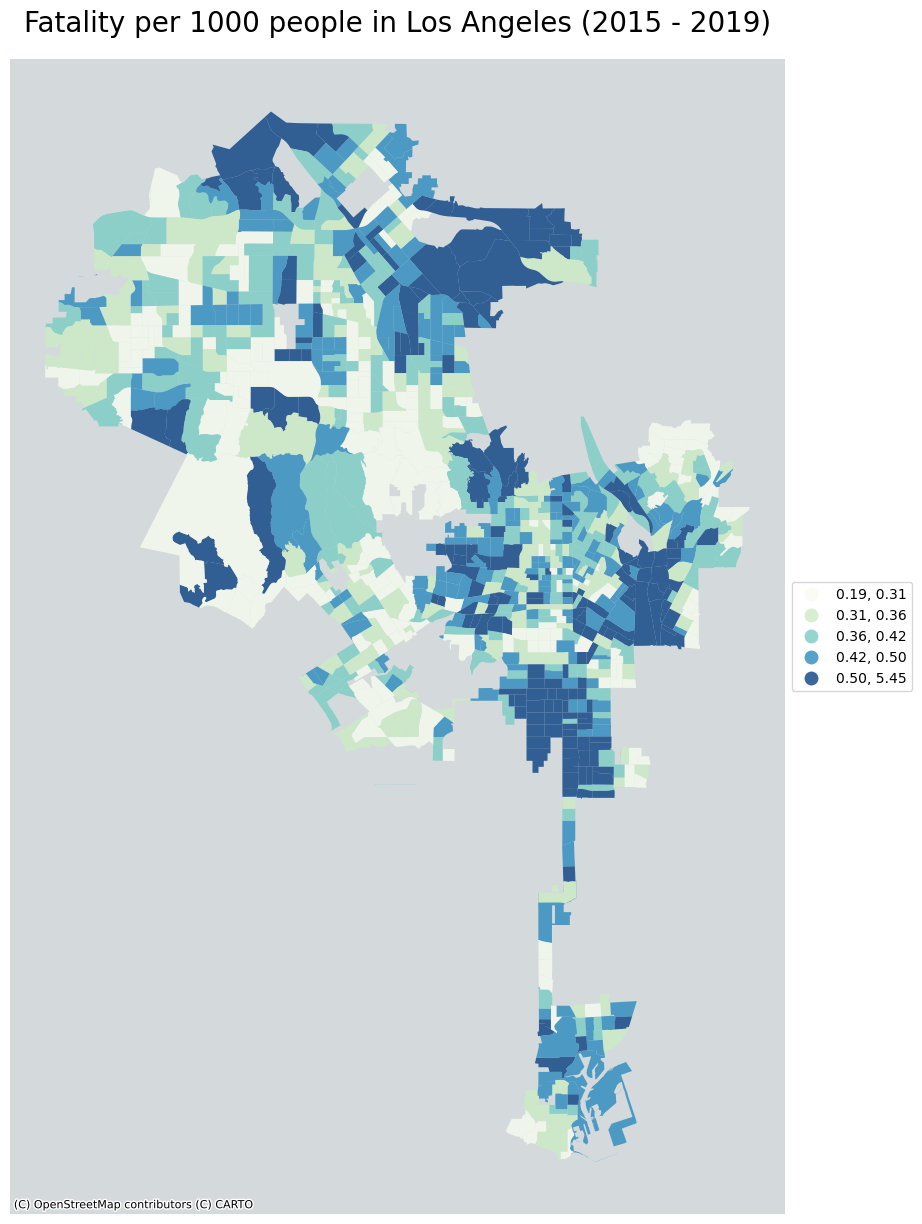

In [286]:
# spatial lag map - mapping the entire dataframe
#good map - appears to confirm the people of color map but we need support from stats..
# why is this quanitiles? - Maybe because we applied the weight to "killed_per_1000_lag"? or should we use natural breaks  

fig, ax = plt.subplots(figsize=(15, 15))

la_city.plot(ax=ax,
         figsize=(15,15),
         column='killed_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='GnBu',
         scheme='quantiles', 
         legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})

ax.axis('off')
ax.set_title('Fatality per 1000 people in Los Angeles (2015 - 2019)',fontsize=20,pad=20)

ctx.add_basemap(ax,zoom =12, source=ctx.providers.CartoDB.Positron)

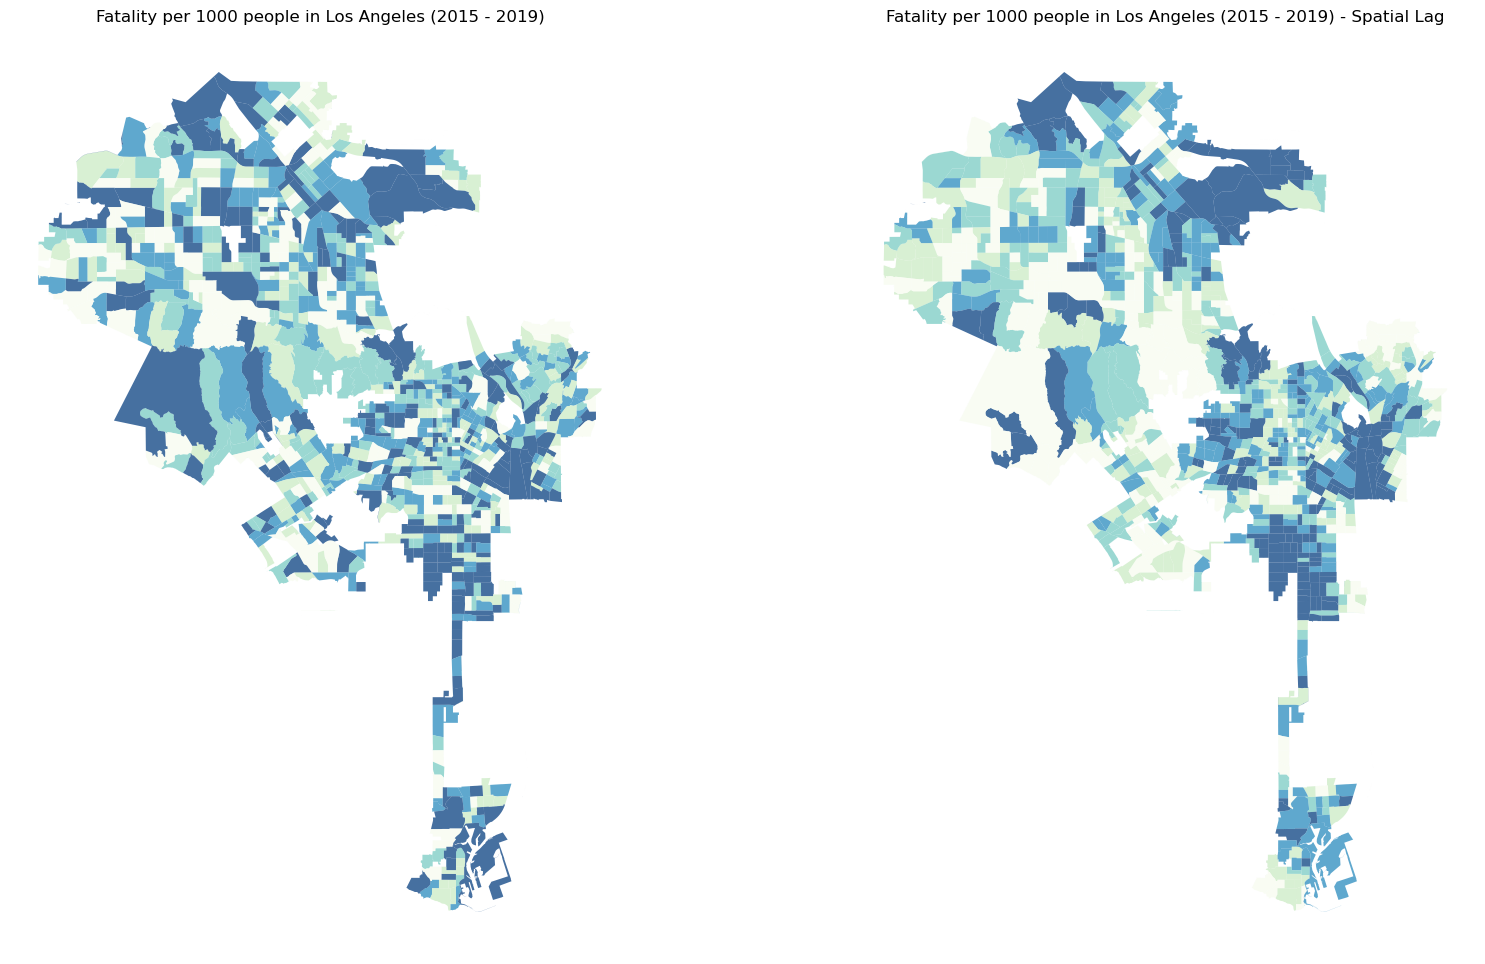

In [287]:
# comparison 
#create a side by side map of People of Color AND fatalities??
#or just find those maps and place them right next to each other because they are in different notebooks+ i removed the race data..
#to keep the info clean here 

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

#ax[0] - map on the left 
la_city.plot(ax=ax[0], # this assigns the map to the left subplot
         column='killed_per_1000', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Fatality per 1000 people in Los Angeles (2015 - 2019)")

# ax[1] - map on the right 
la_city.plot(ax=ax[1], 
         column='killed_per_1000_lag', 
         cmap='GnBu', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Fatality per 1000 people in Los Angeles (2015 - 2019) - Spatial Lag")

plt.show()

In [288]:
la_city.head(2)

FIPS  Census Tract  Total Population  \
0  06037101110        101110              4283   
1  06037101122        101122              3405   

                                            geometry  NUMBER_KILLED  \
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...              1   
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...              1   

   killed_per_1000  killed_per_1000_lag  killed_lag_diff  
0         0.233481             0.534025        -0.300544  
1         0.293686             0.526499        -0.232814

In [289]:
# saving the side by side maps
fig.savefig('Fatality per 1000 people in Los Angeles.png', dpi=300, bbox_inches='tight')

In [290]:
# interactive map 
# what scheme to use - natural breaks or quantiles here? 
# try both - natural breaks  
la_city.explore(
        column='killed_per_1000_lag', 
        legend=True,
        cmap='GnBu', 
        scheme='naturalbreaks',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        ).save('killed_naturalbreaks.html')

# add .save(title.html') at the end to save the explore map

In [291]:
# interactive map 
# what scheme to use - natural breaks or quantiles here? 
# try both - quantiles
la_city.explore(
        column='killed_per_1000_lag', 
        legend=True,
        cmap='GnBu', 
        scheme='quantiles',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        ).save('killedquantiles.html')

# add .save(title.html') at the end to save the explore map

# What we have done so far...

### Found clusters (ex. portions of the Valley, Wilmington, etc) BUT we have not quantified the spatial correlations so we apply Moran'

In [292]:
# finding the slope, I believe - getting the y-values 
# hmmm negative (no on clustering??) 
y = la_city.killed_per_1000  #used the rate and NOT the spatial lag here 
moran = Moran(y, wq)
moran.I

np.float64(-0.004968493977890666)

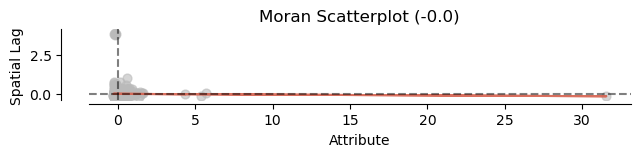

In [293]:
# hmmm need to review 
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.0', ylabel='Density'>)

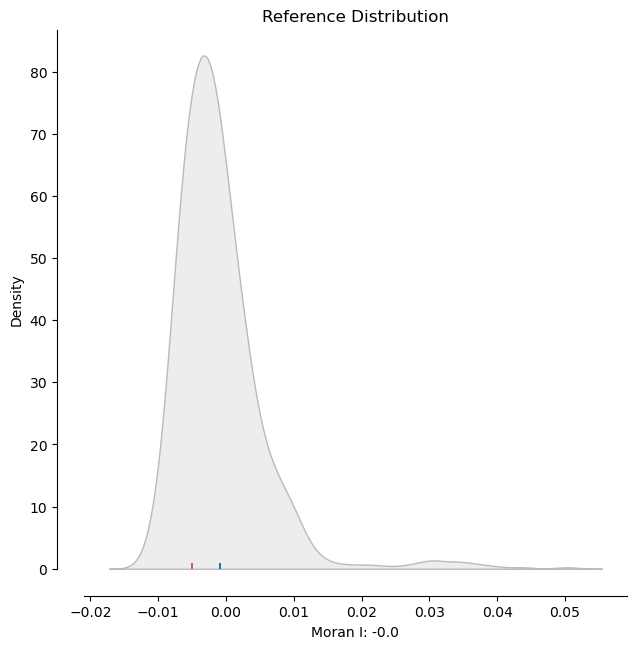

In [294]:
# data is skewed to lower values 
plot_moran_simulation(moran,aspect_equal=False)

In [295]:
# find the p-value 
# so we fail to reject the null hypothesis with a value (no strong evidence) with a p-value of 0.274
# so folks killed is random? 
moran.p_sim

np.float64(0.26)

# Local Spatial Autocorrelation

In [296]:
# y is equal to the rows of killed per 1000 in our census tracts
# wq - spatial weighting matrix of 8 neighbors 
lisa = esda.moran.Moran_Local(y, wq)

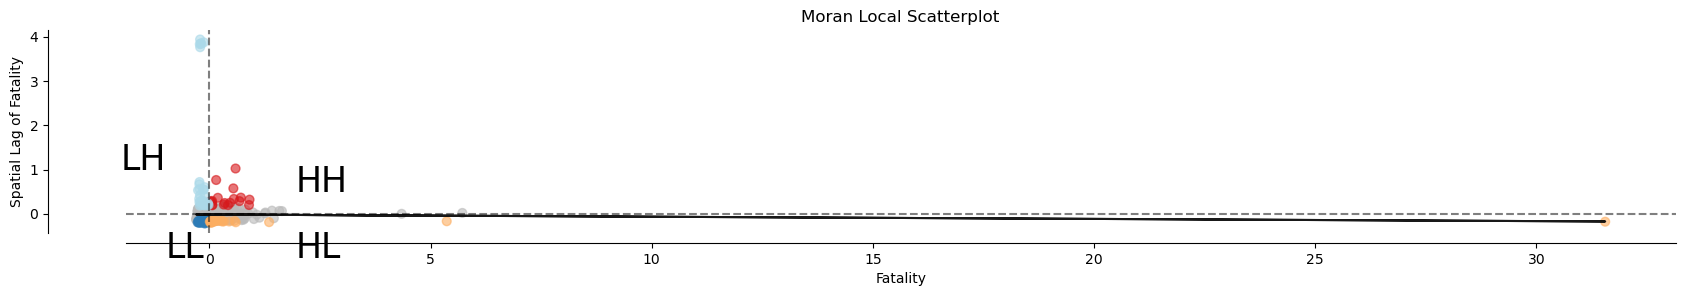

In [297]:
# plot 
# i'm using killed and fatality interchangeably, keep it consistent  
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Fatality")
ax.set_ylabel('Spatial Lag of Fatality')

# test #1 
# nedd to play with the number more?
plt.text(1.95, 0.5, "HH", fontsize=25) 
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

In [298]:
# LISA Classifications
# HH - high fatality rate geographies near other high fatality rate areas 
# LL - low fatality rate geographies near other low fatality rate areas
# LH - (donuts) low fatality rate geographies surrounded by high fatality rate areas 
# HL - (diamonds) high fatality rate geographies surrounded by low fatality rate areas

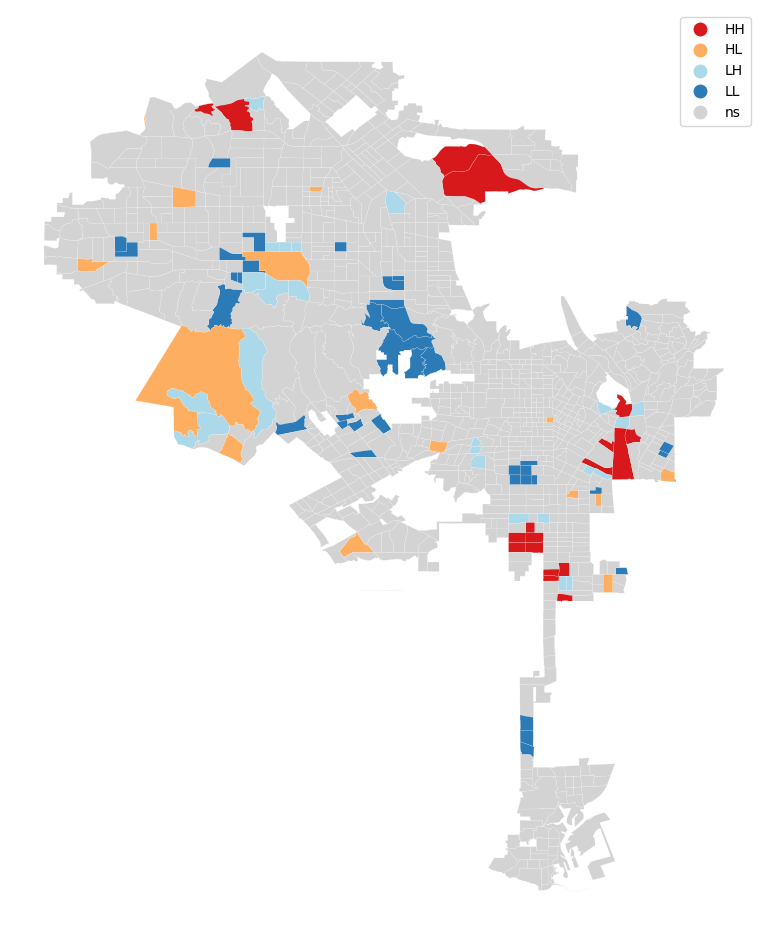

/tmp/ipykernel_170/3602050902.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



In [299]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, la_city, p=0.05, ax=ax)  # should the p-value be changed here? since we got a p-vale of 0.274 
plt.show()

#title and legend is not working 
ax.set_title('LISA for Fatality per 1,000 Residents (2015-2019)')
ax.legend(loc='center left', bbox_to_anchor = (1,0.5))

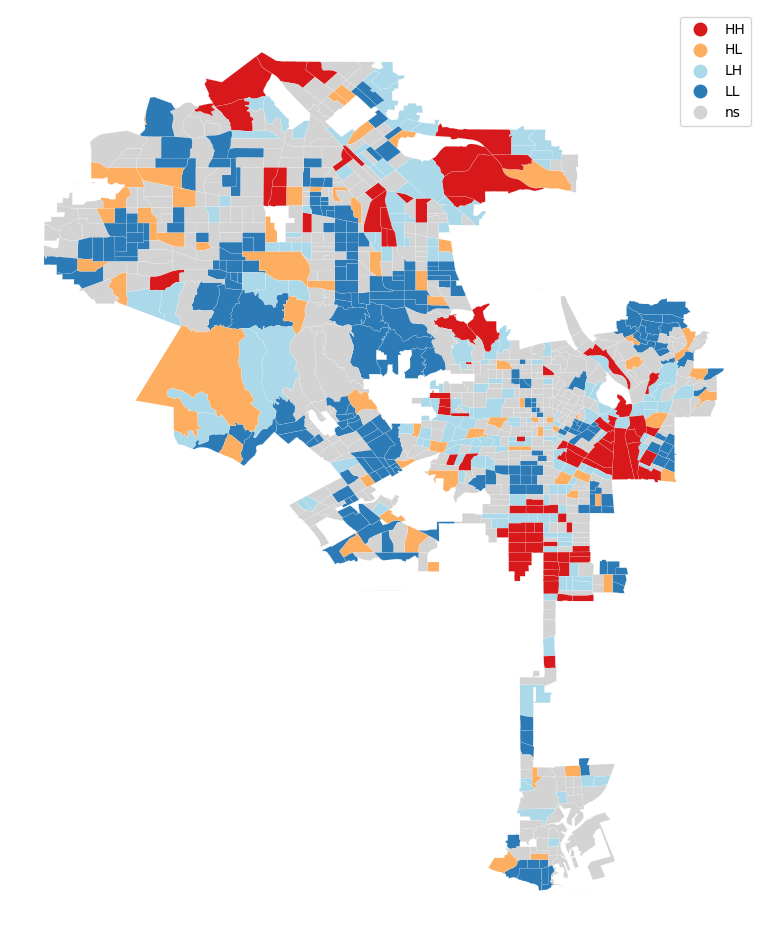

/tmp/ipykernel_170/2400900074.py:12: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



In [300]:
# this map is for experiemntation purposes only 
# set the p-value equal to 0.274
# is this the appropriate map? 
# if so, next step for spatial story and intervention

fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, la_city, p=0.274, ax=ax)  # should the p-value be changed here? since we got a p-vale of 0.274 
plt.show()

#title and legend is not working 
ax.set_title('LISA for Fatality per 1,000 Residents (2015-2019)')
ax.legend(loc='upper right', bbox_to_anchor = (1,0.5))

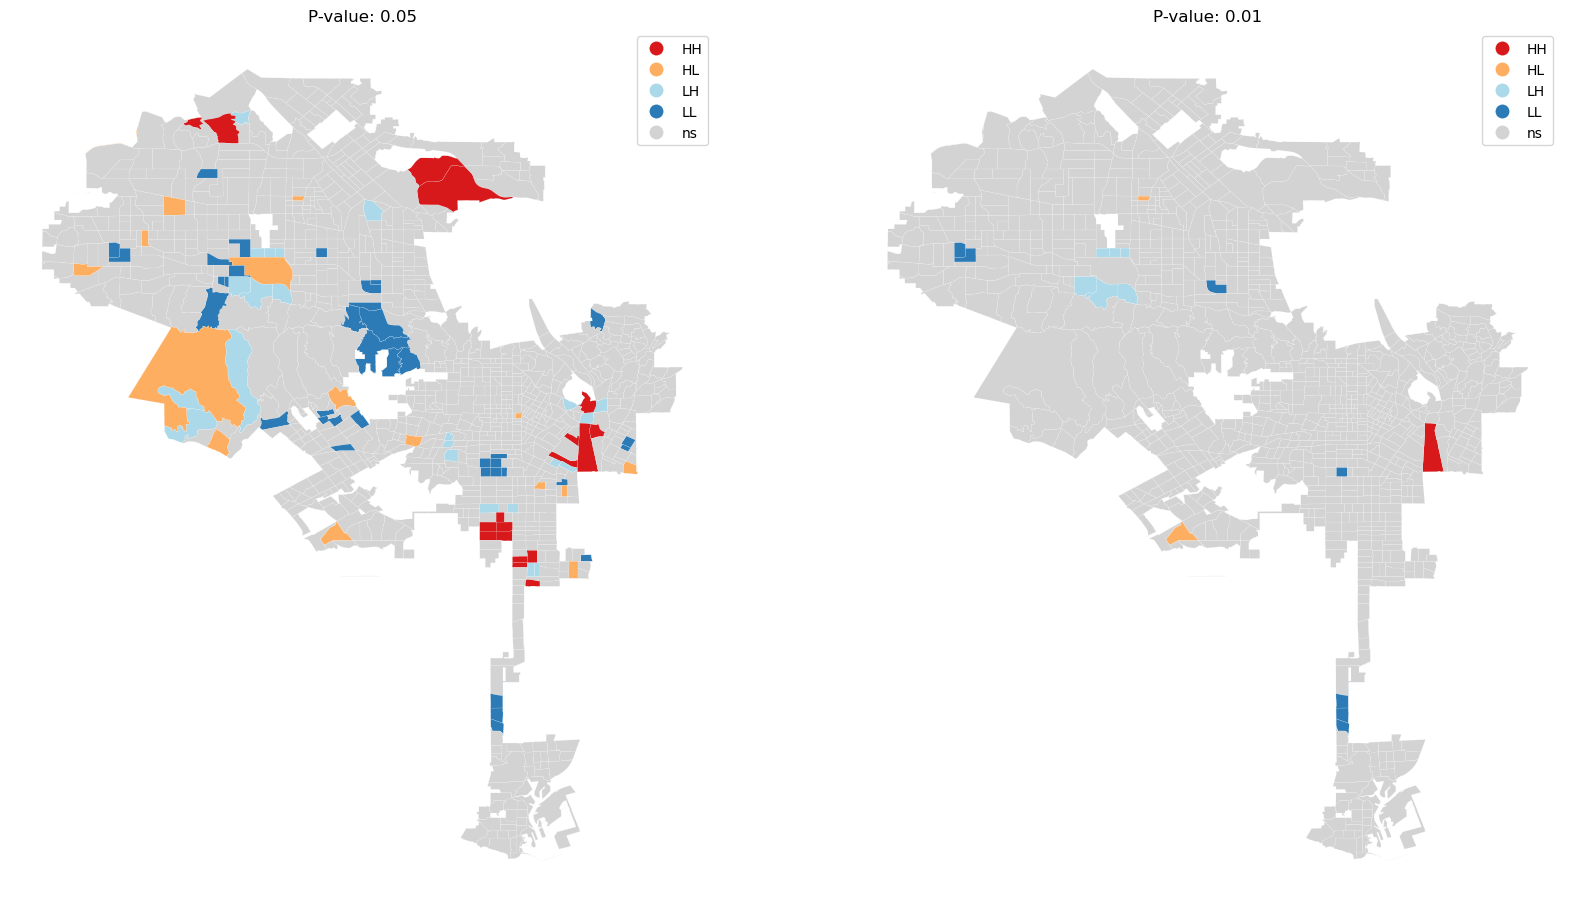

In [301]:
# side by side plot
# added this map, but my p-value from above (.274) confuses me. In the meantime, I am sticking to 0.05 and .01 until I learn more during office hours
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# ax[0] - map on left 
lisa_cluster(lisa, la_city, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# ax[1] - map on right 
lisa_cluster(lisa, la_city, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()


# Crash & Fatality Tables 

In [302]:
crash.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 81 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CASE_ID                  1332 non-null   int64   
 1   ACCIDENT_YEAR            1332 non-null   int64   
 2   PROC_DATE                1332 non-null   object  
 3   JURIS                    1332 non-null   int64   
 4   COLLISION_DATE           1332 non-null   object  
 5   COLLISION_TIME           1332 non-null   int64   
 6   OFFICER_ID               1330 non-null   object  
 7   REPORTING_DISTRICT       1067 non-null   object  
 8   DAY_OF_WEEK              1332 non-null   int64   
 9   CHP_SHIFT                1332 non-null   int64   
 10  POPULATION               1332 non-null   int64   
 11  CNTY_CITY_LOC            1332 non-null   int64   
 12  SPECIAL_COND             1332 non-null   int64   
 13  BEAT_TYPE                1332 non-null   int64   
 14  

In [303]:
crash.sample(2)

CASE_ID  ACCIDENT_YEAR   PROC_DATE  JURIS COLLISION_DATE  COLLISION_TIME  \
98   6718351           2015  2017-04-04   1942     2015-01-06            1400   
148  6854765           2015  2015-07-16   1942     2015-06-20            2105   

    OFFICER_ID REPORTING_DISTRICT  DAY_OF_WEEK  CHP_SHIFT  ...  \
98       39028               1213            2          5  ...   
148      38995               1988            6          5  ...   

     COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP  LATITUDE LONGITUDE  \
98                  0            -               -        NaN       NaN   
148                 0            -               -        NaN       NaN   

          COUNTY         CITY     POINT_X    POINT_Y  \
98   LOS ANGELES  LOS ANGELES -118.309683  33.993248   
148  LOS ANGELES  LOS ANGELES -118.429650  34.228930   

                        geometry  
98   POINT (-118.30968 33.99325)  
148  POINT (-118.42965 34.22893)  

[2 rows x 81 columns]

In [304]:
# find the sum for ped killed, bicyclist killed and motorcyclist killed 
print(crash['COUNT_PED_KILLED'].sum())
print(crash['COUNT_BICYCLIST_KILLED'].sum())
print(crash['COUNT_MC_KILLED'].sum())

629
93
233


In [305]:
# killed stats 
fatality_type = pd.DataFrame({'Fatality Type':['Pedestrian', 'Bicyclist', 'Motorcyclist'], 
                   'Fatality Count':[629, 93, 233], 
                   'Color':['#1f77b4', '#ff7f0e', '#2ca02c',]}) 

fatality_type

Fatality Type  Fatality Count    Color
0    Pedestrian             629  #1f77b4
1     Bicyclist              93  #ff7f0e
2  Motorcyclist             233  #2ca02c

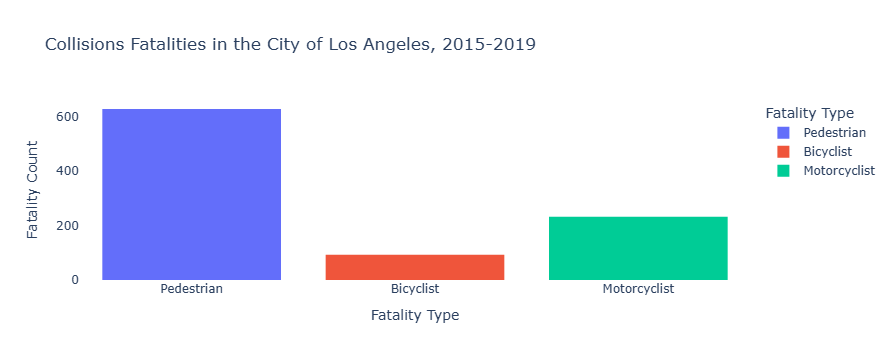

In [307]:
# used plotly for bar graph 
# by dataset does not include those killed in a car accident...
fig = px.bar(fatality_type, 
       x='Fatality Type',
       y='Fatality Count',
       title='Collisions Fatalities in the City of Los Angeles, 2015-2019',
       color='Fatality Type',)
    
# get rid of white lines inside the bars
fig.update_traces(marker_line_width=0)

#transparency 
fig.update_layout(xaxis_tickangle=0, 
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)'
                 )

fig.show()

# click the download image (upper right hand...around zoom) to download the image 